# B-Cubed DEMO BioSpace25
## Building data cubes



### Install missing packages

In [ ]:
%pip install pygbif
%pip install dask
%pip install geopandas
%pip install netCDF4
%pip install rioxarray
%pip install cartopy
%pip install basemap

### Loading packages

In [1]:
from pygbif import occurrences as occ
import pandas as pd
import geopandas as gpd
from pyproj import Proj, Transformer
from shapely.geometry import mapping
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


import io
from io import StringIO
import zipfile
import math

### Loading Earth Engine

### Example of the GBIF API through pygbif

In [4]:
from pygbif import occurrences
data = occurrences.search(speciesKey=5229490, limit=10)

print(data['results'])

[{'key': 5011069995, 'datasetKey': 'ba19fc1d-670c-426b-b99d-49f003792ac4', 'publishingOrgKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'installationKey': 'd973e647-8f5f-4e6e-a1c6-65930deb0590', 'hostingOrganizationKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'publishingCountry': 'RU', 'protocol': 'DWC_ARCHIVE', 'lastCrawled': '2025-01-22T20:14:44.646+00:00', 'lastParsed': '2025-01-22T20:38:27.131+00:00', 'crawlId': 303, 'projectId': 'N-Eurasia-Russia2021', 'programmeAcronym': 'N-Eurasia', 'extensions': {}, 'basisOfRecord': 'MACHINE_OBSERVATION', 'individualCount': 1, 'occurrenceStatus': 'PRESENT', 'taxonKey': 5229490, 'kingdomKey': 1, 'phylumKey': 44, 'classKey': 212, 'orderKey': 729, 'familyKey': 5235, 'genusKey': 7237083, 'speciesKey': 5229490, 'acceptedTaxonKey': 5229490, 'scientificName': 'Pica pica (Linnaeus, 1758)', 'acceptedScientificName': 'Pica pica (Linnaeus, 1758)', 'kingdom': 'Animalia', 'phylum': 'Chordata', 'order': 'Passeriformes', 'family': 'Corvidae', 'genus': 'Pica',

## GBIF data Cubes

### Generating the Cube

#### Exemplar JSON query for generating a data cube


```
# DON'T EXECUTE THIS CELL. FOR DEMO PUPOSE ONLY #
{
  "sendNotification": true,
  "notificationAddresses": [
    "maarten.trekels@plantentuinmeise.be"
  ],
  "format": "SQL_TSV_ZIP",
  "sql": "SELECT  PRINTF('%04d-%02d', \"year\", \"month\") AS yearMonth,
   GBIF_EEARGCode(10000, decimalLatitude,  decimalLongitude,  COALESCE(coordinateUncertaintyInMeters, 1000) ) AS eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway,
   COUNT(*) AS occurrences,
   COUNT(DISTINCT recordedBy) AS distinctObservers
   FROM  occurrence
   WHERE occurrenceStatus = 'PRESENT'
   AND countryCode = 'BE'
   AND hasCoordinate = TRUE
   AND NOT ARRAY_CONTAINS(issue, 'ZERO_COORDINATE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_OUT_OF_RANGE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_INVALID')
   AND NOT ARRAY_CONTAINS(issue, 'COUNTRY_COORDINATE_MISMATCH')
   AND \"month\" IS NOT NULL
   GROUP BY yearMonth,
   eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway
   ORDER BY  yearMonth DESC,
   eeaCellCode ASC,
   speciesKey ASC"
}


```



## Loading the Data cube in pandas



You can download a pre generated data cube from GitHub or any other online resource

#### Get data from Drive

In [2]:
def convert_to_int(x):
       try:
           return int(x)
       except ValueError:
           return pd.NA  # or np.nan if you prefer NumPy NaNs

data = pd.read_csv('./DEMO_BioSpace25_files/Cube_ZA_QDGC_l3.csv', sep='\t', converters={'familykey': convert_to_int, 'specieskey': convert_to_int})

data['familykey'] = pd.to_numeric(data['familykey'], errors='coerce').astype('Int64')
data['specieskey'] = pd.to_numeric(data['specieskey'], errors='coerce').astype('Int64')


In [ ]:
print(data)

## Getting a Geopackage file from the Grid that you use

In [3]:
# Load QDGC code

input_file = "./DEMO_BioSpace25_files/qdgc_south_africa.gpkg"

qdgc_ref = gpd.read_file(input_file, layer='tbl_qdgc_03')

In [ ]:
print(qdgc_ref)

## Merging the Data cube with the grid

In [4]:
test_merge = pd.merge(data, qdgc_ref, left_on='qdgccode', right_on='qdgc')

In [5]:
# Convert to GeoDataFrame

gdf = gpd.GeoDataFrame(test_merge, geometry='geometry')

gdf = gdf.set_crs(epsg=4326, inplace=False)

## Filtering data (e.g. on species)
Check for a single species (Loxodonta africana: https://www.gbif.org/species/2435350)

In [6]:
filtered_gdf = gdf[gdf['specieskey'].eq(2435350)]

print(filtered_gdf)


         yearmonth    qdgccode  familykey        family  specieskey  \
6401       2024-09  E025S33BAD       9427  Elephantidae     2435350   
6402       2024-09  E025S33BBC       9427  Elephantidae     2435350   
6403       2024-09  E025S33BCA       9427  Elephantidae     2435350   
6405       2024-09  E025S33BCB       9427  Elephantidae     2435350   
6406       2024-09  E025S33BCC       9427  Elephantidae     2435350   
...            ...         ...        ...           ...         ...   
14708306   1990-01  E025S33BCB       9427  Elephantidae     2435350   
14708309   1990-01  E025S33BDA       9427  Elephantidae     2435350   
16222304   1987-01  E031S24BBC       9427  Elephantidae     2435350   
16427602   1985-09  E031S23ABA       9427  Elephantidae     2435350   
16427611   1985-09  E031S23ADD       9427  Elephantidae     2435350   

                     species  occurrences  familycount        qdgc  \
6401      Loxodonta africana           14       5301.0  E025S33BAD   
6402   

In [ ]:
# Free up some RAM

del gdf
del test_merge
del data

## Visualization of the data cubes on a map with different layers

Choosing S2A_MSIL2A_20220513T073621_R092_T36KUV_20220515T130938 from 2022-05-13 with 0.0% cloud cover
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/K/UV/2022/05/13/S2A_MSIL2A_20220513T073621_N0400_R092_T36KUV_20220515T130938.SAFE/GRANULE/L2A_T36KUV_A035982_20220513T080211/IMG_DATA/R10m/T36KUV_20220513T073621_TCI_10m.tif?st=2025-02-10T08%3A01%3A22Z&se=2025-02-11T08%3A46%3A22Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-11T03%3A41%3A40Z&ske=2025-02-18T03%3A41%3A40Z&sks=b&skv=2024-05-04&sig=jJHCy3Fgh5UeHnoC3Vku5DDBuYnc0/Bq18cA39hDjfU%3D


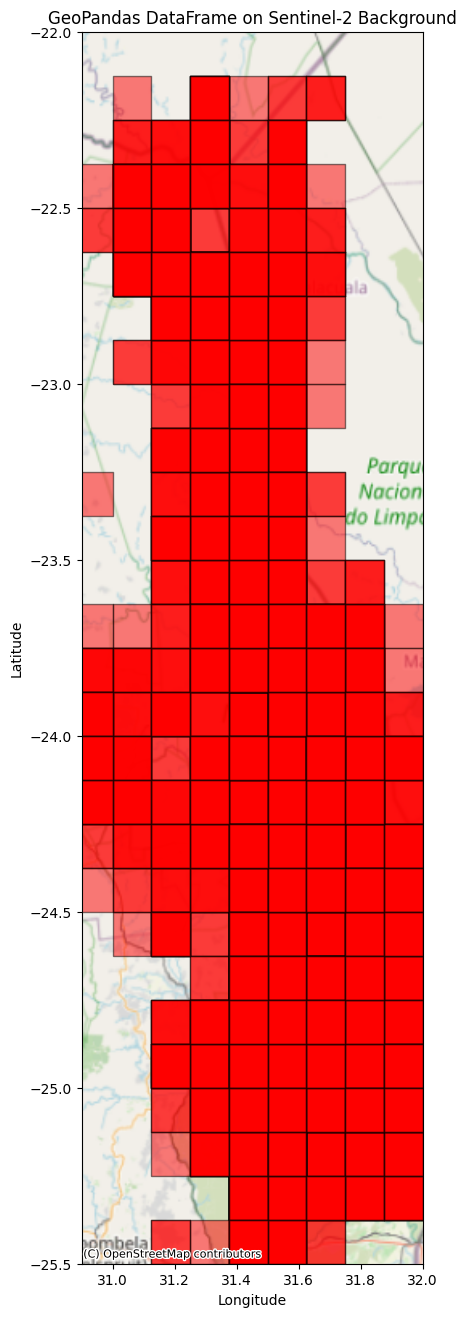

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import rioxarray
import planetary_computer


# 2. Get Sentinel-2 data from Planetary Computer
bbox_total = filtered_gdf.total_bounds
bbox = [30.9, -25.5, 32.0, -22.0] #Kruger bbox

aoi = {
    "type": "Polygon",
    "coordinates": [[
        [bbox[0], bbox[1]],
        [bbox[2], bbox[1]],
        [bbox[2], bbox[3]],
        [bbox[0], bbox[3]],
        [bbox[0], bbox[1]],
    ]],
}

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)


items = catalog.search(
    bbox=bbox,
    datetime="2013-06-01/2022-05-14",  # Adjust date range as needed 11/18/2024 05/13/2022 
    query={"eo:cloud_cover": {"lt": 10}},  # Adjust cloud cover as needed
    collections=["sentinel-2-l2a"],
).items()

least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

# 3. Read the Raster Data
asset = least_cloudy_item.assets["visual"]
print(asset.href)

raster_data = rioxarray.open_rasterio(asset.href, masked=True)

# Check min and max values
min_val, max_val = raster_data.min().item(), raster_data.max().item()

# Normalize data if in 0-255 range
if max_val > 1:
    raster_data = raster_data / 255.0  # Convert to 0-1 range


# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))


# Plot the GeoDataFrame
filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.5)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:4326")


# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

/home/maarten/.local/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


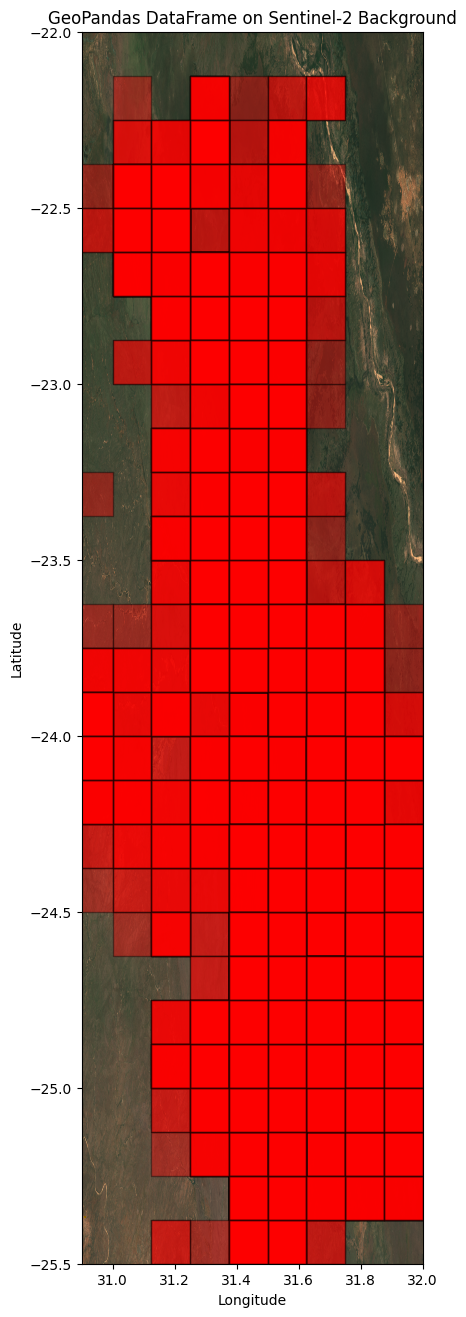

In [ ]:
# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))


raster_data = raster_data.transpose("y", "x", "band")  # Ensure correct shape
ax.imshow(raster_data, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])


# Plot the GeoDataFrame

filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.4)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])


# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

## Export the data to GeoParquet

In [ ]:
#gdf.to_parquet('/content/drive/Shareddrives/BioSpace25/supporting_data/data_ZA.parquet')

# EBV data cubes in NetCDF format

In [3]:
import netCDF4 as nc
import xarray as xr


birds_file = xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc')

print(birds_file)

<xarray.Dataset> Size: 26kB
Dimensions:  (lon: 559, lat: 437, time: 1, entity: 486)
Coordinates:
  * lon      (lon) float64 4kB 9.45e+05 9.55e+05 ... 6.515e+06 6.525e+06
  * lat      (lat) float64 3kB 5.305e+06 5.295e+06 ... 9.55e+05 9.45e+05
  * time     (time) datetime64[ns] 8B 2018-01-01
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Data variables:
    crs      |S1 1B ...
Attributes: (12/38)
    Conventions:                CF-1.8, ACDD-1.3, EBV-1.0
    naming_authority:           The German Centre for Integrative Biodiversit...
    history:                    EBV netCDF created using ebvcube, 2024-02-06
    ebv_vocabulary:             https://portal.geobon.org/api/v1/ebv
    ebv_cube_dimensions:        lon, lat, time, entity
    keywords:                   ebv_class: Species populations, ebv_name: Spe...
    ...                         ...
    geospatial_lat_units:       meter
    time_coverage_start:        2013-01-01
    time_coverage_end:       

In [6]:
def print_netcdf_structure(nc_file_path):
  """Prints the structure (groups, variables, and their paths) of a NetCDF file.

  Args:
    nc_file_path: Path to the NetCDF file.
  """
  def print_group_structure(group, path=""):
    """Recursively prints the structure of a group within the NetCDF file."""
    for var_name in group.variables:
      print(f"{path}/{var_name}")  # Print variable path
    for group_name in group.groups:
      subgroup = group.groups[group_name]
      print_group_structure(subgroup, f"{path}/{group_name}")  # Recursively explore subgroups

  with nc.Dataset(nc_file_path, 'r') as nc_file:
    print_group_structure(nc_file)  # Start with the root group

# Example usage:
nc_file_path = './DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc'
print_netcdf_structure(nc_file_path)

/lon
/lat
/time
/crs
/entity
/metric_1/ebv_cube


In [7]:
print(birds_file.variables)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 559)> Size: 4kB
array([ 945000.,  955000.,  965000., ..., 6505000., 6515000., 6525000.])
Attributes:
    long_name:      lon
    standard_name:  projection_x_coordinate
    axis:           X
    units:          meter, 'lat': <xarray.IndexVariable 'lat' (lat: 437)> Size: 3kB
array([5305000., 5295000., 5285000., ...,  965000.,  955000.,  945000.])
Attributes:
    long_name:      lat
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          meter, 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T, 'crs': <xarray.Variable ()> Size: 1B
[1 values with dtype=|S1]
Attributes:
    spatial_ref:                     PROJCRS["ETRS89-extended / LAEA Europe",...
    GeoTransform:                    940000 10000 0.0 5310000 0.0 -10000
    grid_mapping_name:               lambert_azimuthal_equal_area
    l

In [8]:
time = birds_file.variables['time']
print(time)

print(birds_file['entity'])

<xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T
<xarray.DataArray 'entity' (entity: 486)> Size: 18kB
array([b'Gavia stellata                       ',
       b'Gavia arctica                        ',
       b'Tachybaptus ruficollis               ', ...,
       b'Accipiter gentilis all others        ',
       b'Melanitta nigra s. str.              ',
       b'Sylvia subalpina                     '], dtype='|S37')
Coordinates:
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Attributes:
    units:                           1
    ebv_entity_type:                 Species
    ebv_entity_scope:                Bird species listed under the Art. 12 of...
    ebv_entity_classification_name:  Species names as accepted by the Birds D...
    ebv_entity_classification_url:   https://cdr.eionet.europa.eu/help/birds_...
    long_name:                     

/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


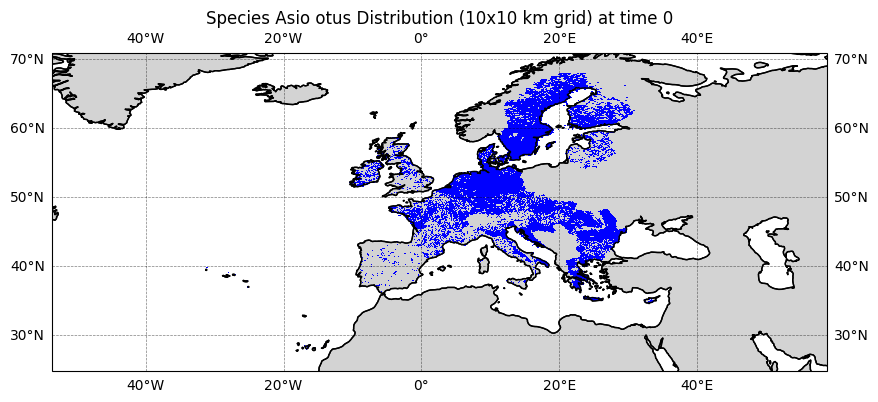

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from pyproj import Transformer
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Load Dataset Efficiently ---
birds_file = xr.open_dataset(
    './DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc',
    group="metric_1",
    chunks={'entity': 1, 'time': 1}  # Load only one entity/time slice at a time
)

# --- Select Target Species and Time ---
species_index = 150  # Change to the species index you need
time_index = 0  # Change to the desired time index

# Extract only the required slice
species_data_subset = birds_file['ebv_cube'].sel(entity=species_index, time=time_index).compute()

# Convert to a 2D array
species_distribution_2d = np.squeeze(species_data_subset)

# --- Load Longitude and Latitude (Only Once) ---
with xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc') as ds:
    lon = ds['lon'].values  # 1D array (size: 559)
    lat = ds['lat'].values  # 1D array (size: 437)

# --- Create Meshgrid Efficiently ---
lon_grid, lat_grid = np.meshgrid(lon, lat)

# --- Efficient Coordinate Transformation ---
transformer = Transformer.from_crs("epsg:3035", "epsg:4326", always_xy=True)

# Transform the entire 2D meshgrid
lon_deg, lat_deg = transformer.transform(lon_grid, lat_grid)

# --- Create the Plot ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# --- 🔹 Fix: Use Discrete Colormap Without Color Bar ---
unique_values = np.unique(species_distribution_2d)

# If only one value, choose a single solid color
if len(unique_values) == 1:
    cmap = ListedColormap(["red"])  # Single-color for uniform data
    norm = None
else:
    cmap = ListedColormap(["white", "blue"])  # Adjust colors as needed
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# --- 🔹 Fix: Use `shading="nearest"` to Ensure Correct Grid Alignment ---
cs = ax.pcolormesh(
    lon_deg, lat_deg, species_distribution_2d,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='nearest'  # Prevents visual distortion
)

# --- 🔹 Completely Remove Color Bar ---
# No `fig.colorbar(cs)`, so no scale bar will be shown

# --- Get the Species Name Efficiently ---
with xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc') as ds:
    species_name = ds['entity'].values[species_index].decode('utf-8').strip()

# --- Final Plot Customization ---
ax.set_title(f"Species {species_name} Distribution (10x10 km grid) at time {birds_file['time'].values[time_index].item()}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# --- 🔹 Fix: Add Grid Lines to Show Exact 10x10 km Cells ---
gridlines = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Show the plot
plt.show()
